In [1]:
# import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# load dataset to dataframe
df = pd.read_csv("dim_charity.csv")
df.head()

,REGISTERED_CHARITY_NUMBER,CHARITY_NAME,CHARITY_TYPE,DATE_OF_REGISTRATION,AGE,LATEST_ACC_FIN_PERIOD_START_DATE,LATEST_ACC_FIN_PERIOD_END_DATE,LATEST_INCOME,LATEST_EXPENDITURE,LATEST_SURPLUS,...,CHARITY_COMPANY_REGISTRATION_NUMBER,IS_REGISTERED_COMPANY,IS_INSOLVENT,IS_IN_ADMINISTRATION,IS_PREVIOUSLY_EXCEPTED,IS_CIO,IS_CIO_DISSOLVED,CHARITY_ACTIVITIES,IS_GIFT_AID,HAS_LAND
0,1089090,THE INDIAN MUSLIM RELIEF COMMITTEE OF THE UK,Other,2001-10-29,25,2023-05-01,2024-04-30,0,0,0,...,NaN,False,False,False,False,False,False,SUMMARY OF MAIN ACTIVITIES AND ACHIEVEMENTSThi...,True,False
1,243053,THE ELLAND SOCIETY,Other,1965-09-15,61,2024-04-01,2025-03-31,5652,7568,-1916,...,NaN,False,False,False,False,False,False,We give grants to men and women who are in tra...,False,False
2,1082789,FRIENDS OF MAIDENBOWER JUNIOR SCHOOL,Other,2000-10-06,26,2023-09-01,2024-08-31,23522,19314,4208,...,NaN,False,False,False,False,False,False,The Charity seeks to enhance the education and...,False,False
3,1084777,REDEEMED CHRISTIAN CHURCH OF GOD ('RCCG') (INS...,Other,2001-01-29,25,2024-01-01,2024-12-31,481262,620173,-138911,...,08097607,True,False,False,False,False,False,Advancement of the christian faith world wide.,True,False
4,1085077,RICKMANSWORTH AND DISTRICT U3A,Other,2001-02-20,25,2024-09-01,2025-08-31,16820,15556,1264,...,NaN,False,False,False,False,False,False,"The advancement of education and, in particula...",True,False


In [5]:
col_list = ['CHARITY_TYPE','AGE', 'LATEST_EXPENDITURE', 'HAS_POST_CODE', 'HAS_PHONE', 'HAS_EMAIL', 'HAS_WEBSITE', 'IS_REGISTERED_COMPANY', 'IS_GIFT_AID', 'HAS_LAND', 'LATEST_INCOME']
df_clean = df[col_list]

# remove 1 row where income is negative
df_clean = df_clean[df_clean["LATEST_INCOME"] >= 0]

# log transforma latest income to reduce skew
# add 1 before log to avoid log(0) for rows with 0 income
df_clean["LOG_LATEST_INCOME"] = np.log1p(df_clean["LATEST_INCOME"])
# df_clean["LOG_AGE"] = np.log1p(df_clean["AGE"])
df_clean["LOG_LATEST_EXPENDITURE"] = np.log1p(df_clean["LATEST_EXPENDITURE"])
df_clean = df_clean.drop(columns=["LATEST_INCOME", "LATEST_EXPENDITURE"])
df_clean.head()

,CHARITY_TYPE,AGE,HAS_POST_CODE,HAS_PHONE,HAS_EMAIL,HAS_WEBSITE,IS_REGISTERED_COMPANY,IS_GIFT_AID,HAS_LAND,LOG_LATEST_INCOME,LOG_LATEST_EXPENDITURE
0,Other,25,True,True,True,False,False,True,False,0.000000,0.000000
1,Other,61,True,True,True,True,False,False,False,8.639942,8.931816
2,Other,26,True,True,False,False,False,False,False,10.065734,9.868637
3,Other,25,True,True,True,True,True,True,False,13.084169,13.337755
4,Other,25,True,True,True,True,False,True,False,9.730383,9.652266


In [7]:
# for each column, check null count
for c in df_clean.columns:
    print(c, df_clean[c].isnull().sum())
    
print('LOG_LATEST_INCOME', df_clean["LOG_LATEST_INCOME"].isnull().sum())

CHARITY_TYPE 0
AGE 0
HAS_POST_CODE 0
HAS_PHONE 0
HAS_EMAIL 0
HAS_WEBSITE 0
IS_REGISTERED_COMPANY 0
IS_GIFT_AID 2904
HAS_LAND 1533
LOG_LATEST_INCOME 0
LOG_LATEST_EXPENDITURE 0
LOG_LATEST_INCOME 0


In [8]:
# drop nulls from feature_df
df_clean = df_clean.dropna()
# check no nulls
for c in df_clean.columns:
    print(c, df_clean[c].isnull().sum())

CHARITY_TYPE 0
AGE 0
HAS_POST_CODE 0
HAS_PHONE 0
HAS_EMAIL 0
HAS_WEBSITE 0
IS_REGISTERED_COMPANY 0
IS_GIFT_AID 0
HAS_LAND 0
LOG_LATEST_INCOME 0
LOG_LATEST_EXPENDITURE 0


### One-hot Encoding

CHARITY_TYPE is a categorical variable with values:
- CIO                    
- Charitable company     
- Other                  
- Previously excepted     
- Trust

In [9]:
# preview distribution of categorical variable
df_clean.groupby(['CHARITY_TYPE'])['CHARITY_TYPE'].count()

CHARITY_TYPE
CIO                    25209
Charitable company     27507
Other                  67353
Previously excepted     3055
Trust                  17649
Name: CHARITY_TYPE, dtype: int64

In [10]:
# apply one-hot encoding to CHARITY_TYPE
ohe = OneHotEncoder(
    drop="first",
    sparse_output=False,
    dtype=bool,
    handle_unknown="ignore"
)

encoded = ohe.fit_transform(df_clean[["CHARITY_TYPE"]])
encoded_df = pd.DataFrame(
    encoded,
    columns=ohe.get_feature_names_out(["CHARITY_TYPE"]),
    index=df_clean.index
)

df_encoded = pd.concat([df_clean.drop(columns=["CHARITY_TYPE"]), encoded_df], axis=1)
df_encoded.head(10)

,AGE,HAS_POST_CODE,HAS_PHONE,HAS_EMAIL,HAS_WEBSITE,IS_REGISTERED_COMPANY,IS_GIFT_AID,HAS_LAND,LOG_LATEST_INCOME,LOG_LATEST_EXPENDITURE,CHARITY_TYPE_Charitable company,CHARITY_TYPE_Other,CHARITY_TYPE_Previously excepted,CHARITY_TYPE_Trust
0,25,True,True,True,False,False,True,False,0.000000,0.000000,False,True,False,False
1,61,True,True,True,True,False,False,False,8.639942,8.931816,False,True,False,False
2,26,True,True,False,False,False,False,False,10.065734,9.868637,False,True,False,False
3,25,True,True,True,True,True,True,False,13.084169,13.337755,False,True,False,False
4,25,True,True,True,True,False,True,False,9.730383,9.652266,False,True,False,False
5,60,True,True,True,False,False,True,False,8.112228,8.715552,False,True,False,False
6,60,True,True,True,False,False,False,True,6.411818,6.439350,False,True,False,False
7,25,True,True,True,False,False,False,True,0.000000,11.153934,False,False,False,True
8,60,True,True,True,False,False,False,False,11.757157,11.662293,False,False,False,True
9,42,True,True,True,True,False,True,False,9.652202,9.746132,False,True,False,False


In [11]:
# Create feature set X and target variable y
X = df_encoded.copy()
y = df_encoded["LOG_LATEST_INCOME"].copy()

# Split into train and test sets
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=42)
print("Training set shape: X_train:", X_train.shape, "y_train:", y_train.shape)
print("Remaining set shape: X_rem:", X_rem.shape, "y_rem:", y_rem.shape)

X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)
print("Validation set shape: X_val:", X_val.shape, "y_val:", y_val.shape)
print("Testing set shape: X_test:", X_test.shape, "y_test:", y_test.shape)

Training set shape: X_train: (84463, 14) y_train: (84463,)
Remaining set shape: X_rem: (56310, 14) y_rem: (56310,)
Validation set shape: X_val: (28155, 14) y_val: (28155,)
Testing set shape: X_test: (28155, 14) y_test: (28155,)


In [ ]:
# check each column in X_train for nulls
for c in X_train.columns:
    print(c, X_train[c].isnull().sum())

AGE 0
HAS_POST_CODE 0
HAS_PHONE 0
HAS_EMAIL 0
HAS_WEBSITE 0
IS_REGISTERED_COMPANY 0
IS_GIFT_AID 0
HAS_LAND 0
LOG_LATEST_INCOME 0
LOG_LATEST_EXPENDITURE 0
CHARITY_TYPE_Charitable company 0
CHARITY_TYPE_Other 0
CHARITY_TYPE_Previously excepted 0
CHARITY_TYPE_Trust 0


In [13]:
# Initialise the models
linear_regressor = LinearRegression()
tree_regressor = DecisionTreeRegressor(random_state=42)
forest_regressor = RandomForestRegressor(random_state=42)

# Fit the models
linear_regressor.fit(X_train, y_train)
tree_regressor.fit(X_train, y_train)
forest_regressor.fit(X_train, y_train)

# Predict
y_pred_linear_log = linear_regressor.predict(X_test)
y_pred_tree_log = tree_regressor.predict(X_test)
y_pred_forest_log = forest_regressor.predict(X_test)

# Inverse log transform predictions to get back to original scale
y_pred_linear = np.expm1(y_pred_linear_log)
y_pred_tree = np.expm1(y_pred_tree_log)
y_pred_forest = np.expm1(y_pred_forest_log)

y_test_original = np.expm1(y_test) 


### Performance Measures

In [14]:
# Mean Average Error (MAE)
mae_linear = mean_absolute_error(y_test_original, y_pred_linear)
mae_tree = mean_absolute_error(y_test_original, y_pred_tree)
mae_forest = mean_absolute_error(y_test_original, y_pred_forest)


print(f"MAE (Linear Regression): {mae_linear:.2f}")
print(f"MAE (Decision Tree Regression): {mae_tree:.2f}")
print(f"MAE (Random Forest Regression): {mae_forest:.2f}")

def inverse_log_transform(log_value):
    return np.expm1(log_value)
# for i in range(100):
#     print(f"Actual: {inverse_log_transform(y_test.iloc[i]):.2f}, Linear Predicted: {inverse_log_transform(y_pred_linear[i]):.2f}, Tree Predicted: {inverse_log_transform(y_pred_tree[i]):.2f}, Forest Predicted: {inverse_log_transform(y_pred_forest[i]):.2f}")

# Mean Squared Error (MSE)
mse_linear = mean_squared_error(y_test_original, y_pred_linear)
mse_tree = mean_squared_error(y_test_original, y_pred_tree)
mse_forest = mean_squared_error(y_test_original, y_pred_forest)

print(f"MSE (Linear Regression): {mse_linear:.2f}")
print(f"MSE (Decision Tree Regression): {mse_tree:.2f}")
print(f"MSE (Random Forest Regression): {mse_forest:.2f}")

# Root mean squared error (RMSE)
rmse_linear = np.sqrt(mse_linear)
rmse_tree = np.sqrt(mse_tree)
rmse_forest = np.sqrt(mse_forest)

print(f"RMSE (Linear Regression): {rmse_linear:.2f}")
print(f"RMSE (Decision Tree Regression): {rmse_tree:.2f}")
print(f"RMSE (Random Forest Regression): {rmse_forest:.2f}")

r2_linear = r2_score(y_test_original, y_pred_linear)
r2_tree = r2_score(y_test_original, y_pred_tree)
r2_forest = r2_score(y_test_original, y_pred_forest)

print(f"R² (Linear Regression): {r2_linear:.2f}")
print(f"R² (Decision Tree Regression): {r2_tree:.2f}")
print(f"R² (Random Forest Regression): {r2_forest:.2f}")

# Adjusted R² accounts for the number of predictors in the model and the sample size, providing a more accurate measure of
def adjusted_r2_score(r2, X, y):
    n = X.shape[0]
    p = X.shape[1]
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

adj_r2_linear = adjusted_r2_score(r2_linear, X_test, y_test_original)
adj_r2_tree = adjusted_r2_score(r2_tree, X_test, y_test_original)
adj_r2_forest = adjusted_r2_score(r2_forest, X_test, y_test_original)

print(f"Adjusted R² (Linear Regression): {adj_r2_linear:.2f}")
print(f"Adjusted R² (Decision Tree Regression): {adj_r2_tree:.2f}")
print(f"Adjusted R² (Random Forest Regression): {adj_r2_forest:.2f}")

MAE (Linear Regression): 0.00
MAE (Decision Tree Regression): 24975.66
MAE (Random Forest Regression): 31462.04
MSE (Linear Regression): 0.00
MSE (Decision Tree Regression): 3694181848597.54
MSE (Random Forest Regression): 6095988177882.57
RMSE (Linear Regression): 0.00
RMSE (Decision Tree Regression): 1922025.45
RMSE (Random Forest Regression): 2469005.50
R² (Linear Regression): 1.00
R² (Decision Tree Regression): 0.98
R² (Random Forest Regression): 0.96
Adjusted R² (Linear Regression): 1.00
Adjusted R² (Decision Tree Regression): 0.98
Adjusted R² (Random Forest Regression): 0.96


In [15]:
metrics_comparison = pd.DataFrame({
    "Metric": ["MAE", "MSE", "RMSE", "R²", "Adjusted R²"],
    "Linear Regression": [mae_linear, mse_linear, rmse_linear, r2_linear, adj_r2_linear],
    "Decision Tree Regression": [mae_tree, mse_tree, rmse_tree, r2_tree, adj_r2_tree],
    "Random Forest Regression": [mae_forest, mse_forest, rmse_forest, r2_forest, adj_r2_forest]
})

metrics_comparison

,Metric,Linear Regression,Decision Tree Regression,Random Forest Regression
0,MAE,2.112011e-08,2.497566e+04,3.146204e+04
1,MSE,1.565153e-13,3.694182e+12,6.095988e+12
2,RMSE,3.956202e-07,1.922025e+06,2.469006e+06
3,R²,1.000000e+00,9.760630e-01,9.605001e-01
4,Adjusted R²,1.000000e+00,9.760510e-01,9.604804e-01


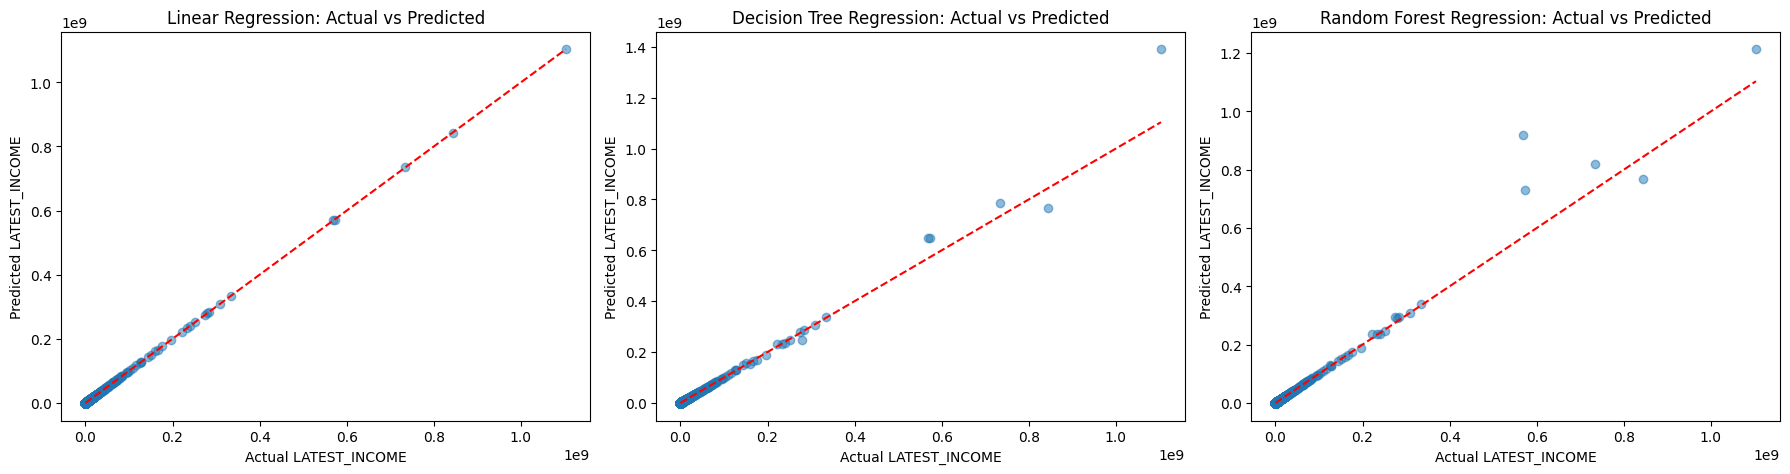

In [16]:
## Plot predicted vs actual values for each model
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(y_test_original, y_pred_linear, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--')
plt.xlabel("Actual LATEST_INCOME")
plt.ylabel("Predicted LATEST_INCOME")
plt.title("Linear Regression: Actual vs Predicted") 
plt.subplot(1, 3, 2)
plt.scatter(y_test_original, y_pred_tree, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--')
plt.xlabel("Actual LATEST_INCOME")
plt.ylabel("Predicted LATEST_INCOME")
plt.title("Decision Tree Regression: Actual vs Predicted")
plt.subplot(1, 3, 3)
plt.scatter(y_test_original, y_pred_forest, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--')
plt.xlabel("Actual LATEST_INCOME") 
plt.ylabel("Predicted LATEST_INCOME")
plt.title("Random Forest Regression: Actual vs Predicted")
plt.tight_layout()
plt.show()